In [2]:
import jax
import jax.numpy as np
from jax import random, grad, vmap, jit, hessian, lax
from jax.example_libraries import optimizers
from jax.nn import relu
from jax.config import config
from jax.numpy import index_exp as index
from jax.flatten_util import ravel_pytree
from jax.experimental.ode import odeint
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import griddata
%matplotlib inline

In [ ]:
# !pip show jax
# !pip show jaxlib

In [ ]:
# !pip uninstall -y jax jaxlib
# !pip install -U jax[cuda11_cudnn82] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# **Physics-informed DeepONets**

We consider parametric PDEs of the form: 
$${\cal N}(u,s)=0$$
where, $u$ is the input function, and $s$ is the unknown PDE's solution (also a function).

Our PDE solution operator would be:
$$G(u):= s$$

Similar to a PINN, a Physics-informed DeepONets output functions consistent with physical constraints by minimizing the residual of an underlying governing law (i.e., linear differential operator).

$$\mathcal{L}_{Residual}(\theta)=\frac{1}{NQ}\sum_{i=1}^{N}\sum_{j=1}^{Q}\left|\mathcal{N}\left({\bf u}_{i}(x),\tilde{G}({\bf u}_{i})(y_{j})\right)\right|^2$$

where $\mathcal{N}$ is a linear differential operator, and $\{y_j\}_{i=1}^{Q}$ are the collocation points.

So the total loss would be:

$$\mathcal{L}(\theta)=\mathcal{L}_{Operator}(\theta)+\mathcal{L}_{Residual}(\theta)$$







# **Problem Setup**



**Heat Equation**

$$\frac{\partial s}{\partial t}=\kappa\frac{\partial^2 s}{\partial x^2}, \quad (x,t)\in [{\rm -\rho\pi,\rho\pi}]\times[0,{\rm T}], \quad \kappa>0$$

$$s(x-\pi,t) = s(x+\pi,t), \quad s(x,0)=\exp\left(-\frac{1}{2\kappa}∫^{x}_{-\pi}u(z)dz\right)$$

where, $\kappa$ denotes the thermal diffusivity, $\ u(x)$ is an initial condition to Burgers' Equation that's $2\pi$-periodic with with zero mean i.e. $\int_{-\pi}^{\pi}{\rm u}(z)dz=0$ and $\rho,{\rm T}\in{\mathbb R}.$

**Note:** We will not use any paired input-output training data for our model. We only know the PDE, initial condition and that the boundary condition is periodic.

**Residual Loss**

Our $\tilde{{\cal G}}$ will map the function $u(x)$ to the Heat solution $s(x,t)$. Hence, we will approximate the implicit solution operator $({\cal G})$ with a PI-DeepONet ($\tilde{{\cal G}}$).

Rearranging the Heat Equation, we get

$$\frac{\partial s_{i}}{\partial t}-\kappa\frac{\partial^2 s_{i}}{\partial x^2}=0$$

So since ideally $\tilde{{\cal G}}({\bf u}_{i})(x,t)\approx {\cal G}(u_{i})(x,t):= s_{i}(x,t)$,

$$\frac{\partial \tilde{{\cal G}}({\bf u}_{i})(x,t)}{\partial t}-\kappa\frac{\partial^2 \tilde{{\cal G}}({\bf u}_{i})(x,t)}{\partial x^2}\approx 0$$

Lets call:
$$\tilde{R}_{i}(x,t)=\frac{\partial \tilde{{\cal G}}({\bf u}_{i})(x,t)}{\partial t}-\kappa\frac{\partial^2 \tilde{{\cal G}}({\bf u}_{i})(x,t)}{\partial x^2} $$

So our $\mathcal{L}_{Residual}$ will be
$$\mathcal{L}_{Residual}(\theta)=\frac{1}{N_{\rm train}P_{\rm train}}\sum_{i=1}^{N_{\rm train}}\sum_{j=1}^{P_{\rm train}}\left|\tilde{R}_{i}(x_{\rm i,j}^{(\zeta)},t_{\rm i,j}^{(\zeta)})\right|^2,$$

where $(x_{j}^{\rm (\zeta)},t_{j}^{(\zeta)})$ are the *collocation points* (i.e. points in our domain where we evaluate the PDE, denoted by $\zeta$). 


**Boundary and Initial Conidition Losses**

Since we are working with periodic boundary conditions, we require $\tilde{{\cal G}}({\bf u}_{i})(x_{j}-\pi,t_{j})=\tilde{{\cal G}}({\bf u}_{i})(x_{j}+\pi,t_{j})$ and

$$\mathcal{L}_{Boundary}(\theta)=\frac{1}{N_{\rm train}P_{\rm train}}\sum_{\rm i=1}^{N_{\rm train}}\sum_{\rm j=1}^{P_{\rm train}}\left|\tilde{{\cal G}}({\bf u}_{\rm i})(x_{\rm i,j}^{(\zeta)}-\pi,t_{\rm i,j}^{\rm (\zeta)}) - \tilde{{\cal G}}({\bf u}_{\rm i})(x_{\rm i,j}^{\rm (\zeta)}+\pi,t_{\rm i,j}^{(\zeta)})\right|^2,$$

where $x_{\rm i,j}^{\rm (\zeta)},t_{\rm i,j}^{(\zeta)}$ are the same uniformly sampled collocation points from the residual loss.

Lastly, we will enforce our initial condition with the following loss function

$$\mathcal{L}_{Initial}(\theta)=\frac{1}{N_{\rm train}P_{\rm train}}\sum_{\rm i=1}^{N_{\rm train}}\sum_{\rm j=1}^{P_{\rm train}}\left|\tilde{\cal G}({\bf u}_{\rm i})(x_{\rm i,j}^{(\iota)},0) - \exp\left(-\frac{1}{2\kappa}∫^{x_{\rm i,j}^{(\iota)}}_{-\pi}{\rm u}_{\rm i}(z)dz\right)\right|^2,$$

where the $x_{\rm i,j}^{\rm (\iota)}$ points are uniformly sampled from $[{\rm -\rho\pi,\rho\pi}]$ denoted by $\iota$. 

Finally, the total loss will be 
$$\mathcal{L}(\theta)=\mathcal{L}_{Residual}(\theta)+{w}_1\cdot\mathcal{L}_{Boundary}(\theta)+{w}_2 \cdot \mathcal{L}_{Initial}(\theta) , \ {w}_1,{w}_2>0$$

**Training data**

$\bullet \ $ For ${\cal L}_{Residual}(\theta)$ we have, 

$u_{\rm train}\in{\mathbb R}^{N_{\rm train} \ \times \ {\rm m}}=$ Evaluations of the input functions at the $m$ sensors $\left(i.e. \ {\mathbf u}_{\rm i}(x)=[{\rm u}_{\rm i}(x_1), {\rm u}_{\rm i}(x_2), \dots, {\rm u}_{\rm i}(x_{\rm m})] \ \ \forall {\rm i} \in N_{\rm train} \right)$.

$y_{\rm train}\in{\mathbb R}^{N_{\rm train} \ \times \ P_{\rm train} \ \times \ 2}= $ A set of uniformly sampled collocation points for each input $\left(i.e. \ (x_{\rm i,j},t_{\rm i,j})\sim{\cal U}\left(\left([{\rm -\rho\pi,\rho\pi}]\times(0,T)\right)^{P_{\rm train}}\right)\forall {\rm i} \in N_{\rm train}\right)$

$$\underset{Training \ Data \ Required \ to \ Compute \ Residual \ Loss}{\underbrace {u_{\rm train}, \ y_{\rm train}}.}$$

$\bullet \ $ For ${\cal L}_{Boundary}(\theta)$ we have,

$$\underset{Training \ Data \ Required \ to \ Compute \ Boundary \ Loss}{\underbrace {u_{\rm train}, \ y_{{\rm train}}}.}$$

**Note:** We use the same $y_{{\rm train}}$ points to compute both the residual and boundary losses. 

$\bullet \ $ For ${\cal L}_{Initial}(\theta)$ we have,

$y_{\rm train\_ic}\in{\mathbb R}^{N_{\rm train} \ \times \ P_{\rm train} \ \times \ 2}= $ A set of uniformly sampled evaluation points for each input $\left(i.e. \ (x_{\rm i,j},0) \ \text{ for } \ x_{\rm i,j}\sim{\cal U}\left([{\rm -\rho\pi,\rho\pi}]^{P_{\rm train}}\right)\forall {\rm i} \in N_{\rm train}\right)$

$$\underset{Training \ Data \ Required \ to \ Compute \ Initial \ Loss \ \ \ \ \ \ \ \blacksquare}{\underbrace {u_{\rm train}, \ y_{\rm train\_ic}}}$$ 

**Test Data**

$$\mathcal{L}_{Test}(\theta)= \frac{1}{N_{\rm test}P_{\rm test}}\sum_{i=1}^{N_{\rm test}}\sum_{j=1}^{P_{\rm test}}\left|s_i(x_{\rm i,j},t_{\rm i,j}) -\sum_{k=1}^q{\cal N}_{\mathrm{B,k}}(u_i(x_1),u_i(x_2),\dots,u_i(x_m))\cdot{\cal N}_{\mathrm{T,k}}(x_{\rm i,j},t_{\rm i,j})\right|^2$$

$u_{\rm test}\in{\mathbb R}^{N_{\rm test} \ \times \ {\rm m}}=$ Evaluations of the input functions at the $m$ sensors $\left(i.e. \ {\mathbf u}_i(x)=[{\rm u}_i(x_1), {\rm u}_i(x_2), \dots, {\rm u}_i(x_{\rm m})] \ \forall i \in N_{\rm test} \right)$

$y_{\rm test}\in{\mathbb R}^{N_{\rm test} \ \times \ P_{\rm test} \ \times \ 2}= $ A set of uniformly sampled collocation points for each input $\left(i.e. \ (x_{\rm i,j},t_{\rm i,j})\sim{\cal U}\left(([{\rm -\rho\pi,\rho\pi}]\times(0,T))^{P_{\rm test}}\right)\right)$

$s_{\rm test}\in{\mathbb R}^{N_{\rm test} \ \times \ P_{\rm test}}= $ Numerical solution of PDE at respective collocation points $\left(i.e. \ s_{\rm i}(x_{\rm i,j},t_{\rm i,j}) \ \forall {\rm i} \in N_{\rm test}\right)$ 

$$\underset{Data \ Required \ to \ Compute \ Test \ Loss}{\underbrace {u_{\rm test}, \ y_{\rm test}, \ s_{\rm test}}}$$ 



# **Auxiliary Functions**

We sample initial conditions to Burgers' equation $u_0(x)$, by constructing a sum of sine terms with random coefficients obtained from a zero-mean Gaussian distribution, which yields a function that is 2π-periodic and exhibits zero mean in the interval $[-\pi, \pi]$. 

Specifically, the function takes the form:

$${\rm u}(x) = \sum^{N}_{i=1}c_n{\rm sin}((i+1)x),$$

where $N$ denotes the number of sine terms, $\left(i.e. \ c_n\sim\mathcal{N}(0, A^2)\right)$ represents the sampled coefficients, where $A$ is the amplitude scaling factor.

We then apply the transformation ${\cal T}:u(x) \rightarrow exp\left(-\frac{1}{2\kappa}∫^{x}_{-\pi}u(z)dz\right)$ to generate the respective intial condition for the heat equation.

In [3]:
def generate_fourier_sine(N, A, key):
    """Generate an Fourier Series representation sine function that's 2π-periodic and has zero mean in the interval [-π, π].
    
    Args:
        N (int): Number of sine terms to include in the Fourier series.
        A (float): Amplitude of sine terms.
        key (jax.random.PRNGKey): A random number generator key.
        
    Returns:
        callable: A Fourier-sine function.
    """
    # Generate random coefficients for the sine terms
    coefficients = A * random.normal(key, (N,))

    def sine_function(x):
        sine_terms = np.zeros_like(x)
        for i in range(N):
            sine_terms += coefficients[i] * np.sin((i + 1) * x)
        
        # Set small values to zero
        threshold = 1e-14
        sine_terms = np.where(np.abs(sine_terms) < threshold, 0, sine_terms)
        
        return sine_terms

    return sine_function

In [4]:
# A numerical solver for the heat equation
def solve_heat(key, num_fourier_terms, sine_amplitude, Nx, Nt, T_lim, period, kappa):
  """Solve the 1D heat equation u_t = k * u_xx with an initial condition computed using 
  a Fourier Sine Series function (Burgers' IC) and periodic boundary conditions. 
  Also generate input sensor locations and measurements."""
  xmin, xmax = -period*np.pi, period*np.pi
  tmin, tmax = 0, T_lim
  k = lambda x: kappa * np.ones_like(x)

  # Generate subkeys
  subkeys = random.split(key, 2)

  # Generate an initial condition to Burgers' equation
  fourier_sine_fn = generate_fourier_sine(num_fourier_terms, sine_amplitude, subkeys[0])

  # Create grid
  x = np.linspace(xmin, xmax, Nx)
  t = np.linspace(tmin, tmax, Nt)
  h = x[1] - x[0]
  dt = t[1] - t[0]
  h2 = h ** 2

  # Compute initial condition for the heat equation
  compute_integral_positive_vmap = vmap(compute_integral_positive, in_axes=(None, 0))
  compute_integral_negative_vmap = vmap(compute_integral_negative, in_axes=(None, 0))

  positive_indices = x >= -np.pi
  positive_x = x[positive_indices] #contains elements of x that are >=-π
  negative_x = x[~positive_indices]

  positive_integrals = compute_integral_positive_vmap(fourier_sine_fn, positive_x)
  negative_integrals = compute_integral_negative_vmap(fourier_sine_fn, negative_x)

  integrals = np.concatenate([negative_integrals, positive_integrals])
  u0 = np.exp(-0.5 * (1 / kappa) * integrals)

  # Compute coefficients
  k = k(x)

  # Compute finite difference operators
  D1 = np.eye(Nx, k=1) - np.eye(Nx, k=-1) # first derivative approximation matrix
  D2 = -2 * np.eye(Nx) + np.eye(Nx, k=-1) + np.eye(Nx, k=1)
  D3 = np.eye(Nx - 2) # enforce BCs
  M = -np.diag(D1 @ k) @ D1 - 4 * np.diag(k) @ D2
  m_bond = 8 * h2 / dt * D3 + M[1:-1, 1:-1]
  c = 8 * h2 / dt * D3 - M[1:-1, 1:-1]

  # Initialize solution and apply initial condition
  u = np.zeros((Nx, Nt))
  u = u.at[:, 0].set(u0)
  # Time-stepping update
  def body_fn(i, u):
      b2 = c @ u[1:-1, i].T
      u = u.at[1:-1, i + 1].set(np.linalg.solve(m_bond, b2))
      return u

  s = lax.fori_loop(0, Nt - 1, body_fn, u)

  # Input sensor locations and measurements
  xx = np.linspace(xmin, xmax, m)
  u = fourier_sine_fn(xx)

  return (x, t, s), (u, u0)

In [5]:
# Compute integral of input function from -π to x_j(<-π)
def compute_integral_negative(f_fn, x_j):
    return -compute_integral_positive(f_fn, -np.pi - x_j)

# Compute integral of input function from -π to x_j(>=-π)
def compute_integral_positive(f_fn, x_j):
    y0 = np.array([0.0])  # Initial condition for the integral
    z_values = np.array([-np.pi, x_j])  # We only need the initial and final points

    solution = odeint(lambda y, z: f_fn(z), y0, z_values)
    integral = solution[-1, 0]  # Get the last value of the solution

    # Use lax.cond to conditionally return zero when x_j equals -np.pi
    return lax.cond(np.isclose(x_j, -np.pi), lambda _: 0.0, lambda _: integral, None)


In [11]:
# 3D plot function
def plot_3d(ax, X, T, f):
    surf = ax.plot_surface(X, T, f, cmap='plasma')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$s(x,t)$')

In [7]:
# Color plot function
def plot(ax, X, T, f):
    pcm = ax.pcolor(X, T, f, cmap='plasma')
    plt.colorbar(pcm, ax=ax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')

In [8]:
# Error plot function
def plot_us(x,u,y,s):
  fig, ax1 = plt.subplots(figsize=(8, 6))
  plt.rcParams['font.size'] = '18'
  color='#440154'
  wdt=1.5
  ax1.plot(x,u,'k--',label='$u(x)=ds/dx$',linewidth=wdt)
  ax1.plot(y,s,'-',label='$s(x)=s(0)+\int u(t)dt|_{t=y}$',linewidth=wdt)
  ax1.set_xlabel('x')
  ax1.set_ylabel('u')
  ax1.tick_params(axis='y', color=color)
  ax1.legend(loc = 'lower right', ncol=1)

# **Data Generation**

In [9]:
# Define hyperparameters and grid:
kappa = 0.01
period = 1 # corresponds to rho
T_lim = 20 # corresponds to T

# Resolution of numerical solution (Grid of 100x100)
Nx = 100
Nt = 100

# Initial condition 
num_fourier_terms = 2  # Number of sine terms in the Fourier series
sine_amplitude = 0.02  # Amplitude of the sine terms

# Training data
m = 100   # number of input sensors
N_train = 200 # number of training input samples
P_train = 4000 # number of evaluation points for each training loss

# Test data
N_test = 100 # number of test functions
P_test = 10 # number of test collocation points

### Visualize Numerical Solution of the Heat Equation using a Finite Difference Method

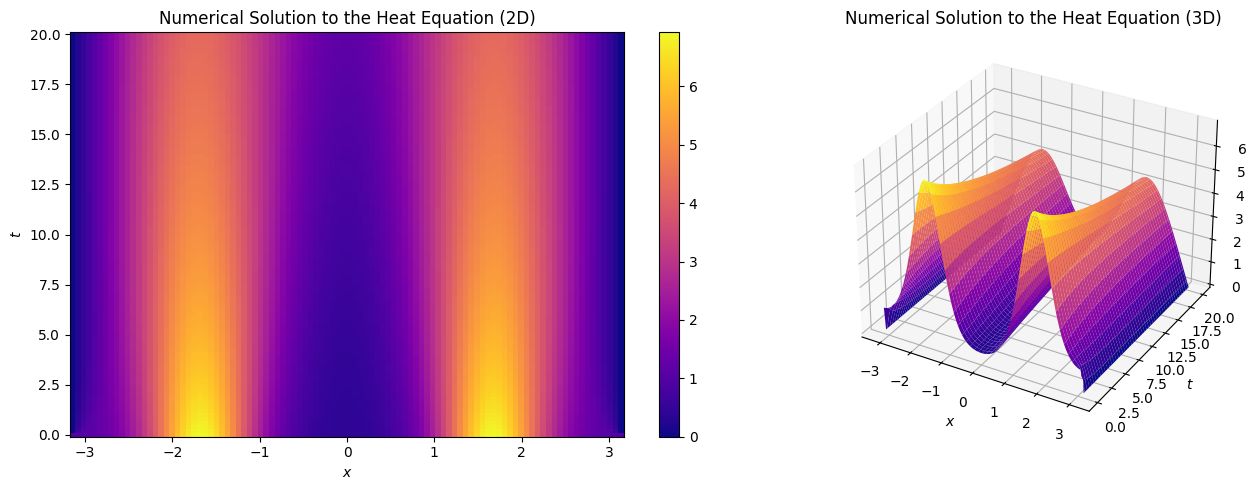

In [12]:
config.update("jax_enable_x64", True)
# Numerical solution
key = random.PRNGKey(11)
(x, t, s), (u, u0) = solve_heat(key, num_fourier_terms, sine_amplitude, Nx , Nt, T_lim, period, kappa)

XX, TT = np.meshgrid(x,t)

# Create a new figure with two subplots side by side, with the first being a 3D plot
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(122, projection='3d')
plot_3d(ax1, XX, TT, s.T)
ax1.set_title('Numerical Solution to the Heat Equation (3D)')

ax2 = fig.add_subplot(121)
plot(ax2, XX, TT, s.T)
ax2.set_title('Numerical Solution to the Heat Equation (2D)')

plt.tight_layout()
plt.show()

## **Generate DeepONet Data**

**Generating Training Data for the Inputs and Initial Condition**

The *solve\_heat* function returns two versions of the initial condition, ${\rm u}$ and ${\rm u}_0$:

${\rm u}$ represents the initial condition to Burgers' equation evaluated at the $m$ sensor points, serving as input functions for the DeepONet, 

${\rm u}_0$ corresponds to the Heat initial condition evaluated at the *Nx*-grid points, utilized as the exact solution values at the initial condition for the loss function calculation.

In the process of generating training data, initial condition (IC) labels are obtained by subsampling the initial condition function $\exp\left(-\frac{1}{2\kappa}∫^{x}_{-\pi}u(z)dz\right)$. The indices *x_2_idx* are randomly selected from the available spatial grid points, which are then used to extract the corresponding values of $\exp\left(-\frac{1}{2\kappa}∫^{x}_{-\pi}u(z)dz\right)$ at these locations (*u0_at_x_2*). This forms the IC labels, s_train_ic, which are paired with the spatial coordinates *x_2* and time values *t_2* (set to zero), generating the input-output pairs for IC training data (*y_train_ic* and *s_train_ic*). 

**Generating Training Data for the Residual**

In the generation of training data, a *dummy* array of zeros, denoted by *s_train_r* is created for the residual loss, serving as the 'label' for the residual loss within the DataGenerator class. The presence of this zero array, despite the lack of a forcing term, is necessary to maintain the expected data structure, ensuring compatibility with the loss function without directly influencing it.

**Structure of the *DataGenerator* Class**

The *DataGenerator* class, is designed to supply seperate batches of training data for each loss function in DeepONet training. It is structured to expect input-output pairs, where $input = (u,y)$, with  ${\rm u}$ representing the input function (i.e. $\rm u$ evaluated at $m$ sensors) and $y$ representing the $(x,t)$ coordinates. The output serves as labelled data evaluated at $y$ (i.e., solution measurements for ${\cal L}_{Residual}(\theta)$, $(x_{\rm j}+\pi,t_{\rm j})$ points for ${\cal L}_{Boundary}(\theta)$, and the true initial condition values for ${\cal L}_{Initial}(\theta).$

For each loss, we formulate training data in triplets to accommodate the data structure expected by the DataGenerator.

In [13]:
# Geneate training data corresponding to one input sample
def generate_one_training_data(key, P):
    # Numerical solution
    (x, t, s), (u, u0) = solve_heat(key, num_fourier_terms, sine_amplitude, Nx , Nt, T_lim, period, kappa)

    # Generate subkeys
    subkeys = random.split(key, 3)

    # Sampled input data at sensor points
    u_train = np.tile(u, (P,1)) # add dimensions-> copy u P times

    # Sample collocation points
    x_1_idx = random.choice(subkeys[0], np.arange(Nx), shape = (P,1)) 
    x_1 = x[x_1_idx]
    t_1 = random.uniform(subkeys[1], minval = 0, maxval = T_lim, shape = (P,1))
    # Training data for Residual
    y_train = np.hstack([x_1, t_1]) # stack coordinates pairwise (x,t) 
    s_train_r = np.zeros((P, 1)) # zero forcing

    # Prepare BC values with a shift of -π and π
    x_1_minus_pi = x_1 - np.pi
    x_1_plus_pi = x_1 + np.pi
    # Training data for BC
    y_train_bc = np.hstack([x_1_minus_pi, t_1]) # boundary values at (x_j-π,t)
    s_train_bc = np.hstack([x_1_plus_pi, t_1])  # boundary values at (x_j+π,t) 

    # Sample IC evaluation points 
    x_2_idx = random.choice(subkeys[2], np.arange(Nx), shape = (P,1)) 
    x_2 = x[x_2_idx] 
    t_2 = np.zeros((P, 1))
    # Training data for IC
    y_train_ic = np.hstack((x_2, t_2))
    s_train_ic = u0[x_2_idx] # initial condition evaluated at x_j points

    return u_train, y_train, s_train_r, y_train_bc, s_train_bc, y_train_ic, s_train_ic

In [14]:
# Geneate test data corresponding to one input sample
def generate_one_test_data(key, P):
    Nx = P
    Nt = P
    (x, t, s), (u, u0) = solve_heat(key, num_fourier_terms, sine_amplitude, Nx , Nt, T_lim, period, kappa)

    XX, TT = np.meshgrid(x, t)

    u_test = np.tile(u, (P**2,1))
    y_test = np.hstack([XX.flatten()[:,None], TT.flatten()[:,None]])
    s_test = s.T.flatten()

    return u_test, y_test, s_test

In [15]:
# Select N keys to create N Functions
key = random.PRNGKey(0)
keys = random.split(key, N_train)

config.update("jax_enable_x64", True)
u_train, y_train, s_train_r, y_train_bc, s_train_bc, y_train_ic, s_train_ic = vmap(generate_one_training_data, (0, None))(keys, P_train)

# Reshape the data into dimensions (N_train*P_train, m) -> each input sample repeated down column P_train times
'''Residual data'''
u_res_train = np.float32(u_train.reshape(N_train * P_train,-1))
y_res_train = np.float32(y_train.reshape(N_train * P_train,-1))
s_res_train = np.float32(s_train_r.reshape(N_train * P_train,-1))

'''Boundary data'''
u_bcs_train = np.float32(u_train.reshape(N_train * P_train,-1))
y_bcs_train = np.float32(y_train_bc.reshape(N_train * P_train,-1))
s_bcs_train = np.float32(s_train_bc.reshape(N_train * P_train,-1))

'''Initial data'''
u_ics_train = np.float32(u_train.reshape(N_train * P_train,-1))
y_ics_train = np.float32(y_train_ic.reshape(N_train * P_train,-1))
s_ics_train = np.float32(s_train_ic.reshape(N_train * P_train,-1))

In [16]:
key = random.PRNGKey(4568) # different key than training data
keys = random.split(key, N_test)

config.update("jax_enable_x64", True)
u_test, y_test, s_test = vmap(generate_one_test_data, (0, None))(keys, P_test)

#Reshape Data
u_test = np.float32(u_test.reshape(N_test * P_test**2,-1))
y_test = np.float32(y_test.reshape(N_test * P_test**2,-1))
s_test = np.float32(s_test.reshape(N_test * P_test**2,-1))

config.update("jax_enable_x64", False)

In [17]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, labels, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input 
        self.y = y # location
        self.labels = labels # labeled data evaluated at y
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx,:]
        y = self.y[idx,:]
        labels = self.labels[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = labels
        return inputs, outputs

# **DeepONet**

In [18]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

In [19]:
# Define the model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=np.tanh)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=np.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=2000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_log = []
        self.loss_bcs_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.loss_test_log = []
        self.loss_AF_test_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, x, t):
        branch_params, trunk_params = params
        y = np.stack([x, t])
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return  outputs
  
    # Define PDE residual
    def residual_net(self, params, u, x, t):
        s = self.operator_net(params, u, x, t)
        s_t = grad(self.operator_net, argnums=3)(params, u, x, t)
        s_xx= grad(grad(self.operator_net, argnums=2), argnums=2)(params, u, x, t)
        res = s_t - kappa * s_xx
        return res

    # Define Residual loss
    def loss_res(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # Compute loss
        loss = np.mean((outputs.flatten() - pred)**2)
        return loss     

    # Define Boundary loss
    def loss_bcs(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        labels = outputs
        # Compute forward pass
        s_pred_minus_pi = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        s_pred_plus_pi = vmap(self.operator_net, (None, 0, 0, 0))(params, u, labels[:,0], labels[:,1])
        # Compute loss
        loss = np.mean((s_pred_minus_pi - s_pred_plus_pi)**2)
        return loss

    # Define Initial loss
    def loss_ics(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # Compute loss
        loss = np.mean((outputs.flatten() - pred)**2)
        return loss 

    # Define Total loss
    def loss(self, params, bcs_batch, res_batch, ics_batch, w_bcs=2.0, w_ics=2.0):
        loss_res = self.loss_res(params, res_batch)
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_ics = self.loss_ics(params, ics_batch)
        loss = loss_res + w_bcs*loss_bcs + w_ics*loss_ics
        return loss 

    # Define Test loss
    def loss_test(self, params, u_test, y_test, s_test):
      s_pred = self.predict_s(params, u_test, y_test)
      return np.mean((s_test - s_pred)**2)

    # Define Average Fractional Test loss
    def AF_loss_test(self, params, u_test, y_test, s_test):
      s_pred = self.predict_s(params, u_test, y_test)
      return np.mean((s_test - s_pred)**2) / np.mean((s_test)**2)

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, bcs_batch, res_batch, ics_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, bcs_batch, res_batch, ics_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, bcs_dataset, res_dataset, ics_dataset, nIter):
        # Define data iterators
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)
        ics_data = iter(ics_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)
            ics_batch = next(ics_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, bcs_batch, res_batch, ics_batch)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, bcs_batch, res_batch, ics_batch)
                loss_bcs_value = self.loss_bcs(params, bcs_batch)
                loss_res_value = self.loss_res(params, res_batch)
                loss_ics_value = self.loss_ics(params, ics_batch)
                loss_test_value = self.loss_test(params, u_test, y_test, s_test)
                AFTL_value = self.AF_loss_test(params, u_test, y_test, s_test)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_test_log.append(loss_test_value)
                self.loss_AF_test_log.append(AFTL_value)

                # Print losses
                pbar.set_postfix({'Training Loss': loss_value, 
                                  'Res Loss': loss_res_value, 'IC Loss': loss_ics_value, 'BC Loss': loss_bcs_value, 
                                  'Test Loss': loss_test_value, 'AFTL': AFTL_value})

    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return r_pred

# **Initialise Dataset and Model**

In [20]:
# Initialize model
branch_layers = [m, 50, 50, 50, 50, 50]
trunk_layers =  [2, 50, 50, 50, 50, 50]
model = PI_DeepONet(branch_layers, trunk_layers)

# Create data set
batch_size = 1000
bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, batch_size)
res_dataset = DataGenerator(u_res_train, y_res_train, s_res_train, batch_size)
ics_dataset = DataGenerator(u_ics_train, y_ics_train, s_ics_train, batch_size)

Average fractional test loss: $\frac{1}{N_{test}}\sum^{N_{test}}_{i=1}\frac{\sum_{j=1}^{P_{test}}(Pred(u_i)(x_j,t_j) - True(u_i)(x_j,t_j))^2}{\sum_{j=1}^{P_{test}} (True(u_i)(x_j,t_j))^2}$

In [40]:
# Train
model.train(bcs_dataset, res_dataset, ics_dataset, nIter=40000)

100%|██████████| 40000/40000 [25:22<00:00, 26.28it/s, Training Loss=0.0045944094, Res Loss=0.0016467806, IC Loss=0.0004803789, BC Loss=0.0009934355, Test Loss=205.3066, AFTL=0.49564528]


# **Evaluate Model**

### **Visualise Results**

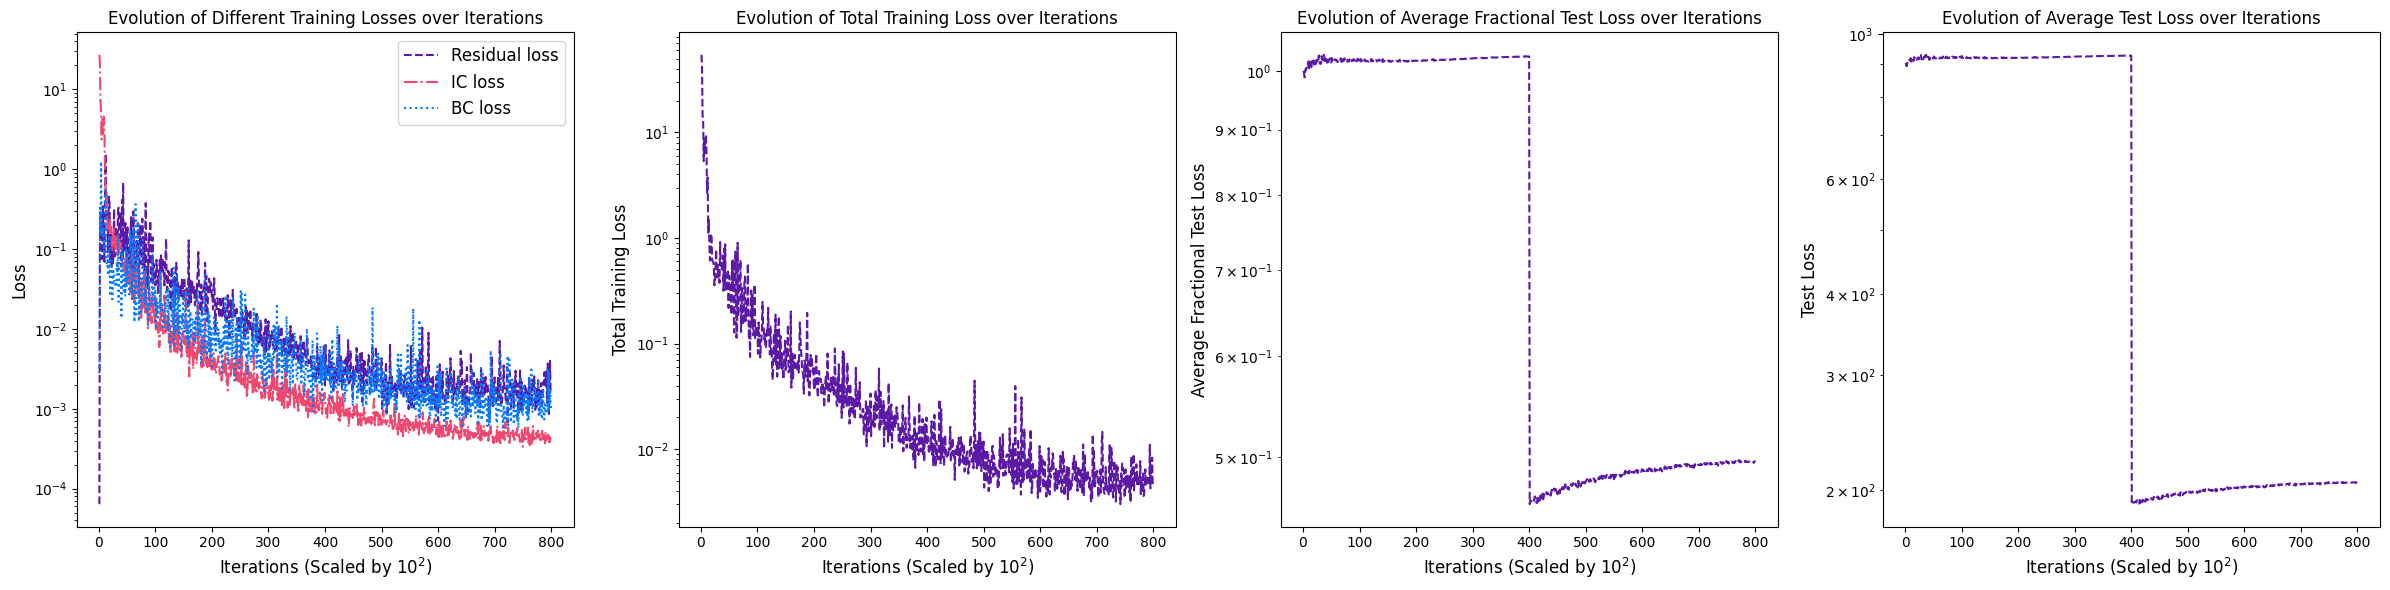

In [47]:
# Visualizations
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Colors from the 'plasma' colormap
medium_purple = '#5B278F'
purple = '#5c19a6'
blue = '#007bff'
orange = '#ef476f'

# Total loss per 100 iteration
total_loss_eval_numbers = range(1, len(model.loss_log) + 1)
axs[1].plot(total_loss_eval_numbers, model.loss_log, '--', color=purple, label='Training loss')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'Iterations (Scaled by $10^2$)', fontsize='large')
axs[1].set_ylabel('Total Training Loss', fontsize='large')
axs[1].set_title('Evolution of Total Training Loss over Iterations', fontsize='large')

# Average fractional test loss
AFTL_eval_numbers = range(1, len(model.loss_AF_test_log) + 1)
axs[2].plot(AFTL_eval_numbers, model.loss_AF_test_log, '--', color=purple, label='Average Fractional Test loss')
axs[2].set_yscale('log')
axs[2].set_xlabel(r'Iterations (Scaled by $10^2$)', fontsize='large')
axs[2].set_ylabel('Average Fractional Test Loss', fontsize='large')
axs[2].set_title('Evolution of Average Fractional Test Loss over Iterations', fontsize='large')

# Test loss
test_loss_eval_numbers = range(1, len(model.loss_test_log) + 1)
axs[3].plot(test_loss_eval_numbers, model.loss_test_log, '--', color=purple, label='Test loss')
axs[3].set_yscale('log')
axs[3].set_xlabel(r'Iterations (Scaled by $10^2$)', fontsize='large')
axs[3].set_ylabel('Test Loss', fontsize='large')
axs[3].set_title('Evolution of Average Test Loss over Iterations', fontsize='large')

# Losses per 100 iteration (residual, IC, and BC)
res_loss_eval_numbers = range(1, len(model.loss_res_log) + 1)
axs[0].plot(res_loss_eval_numbers, model.loss_res_log, '--', color=purple, label='Residual loss')
ics_loss_eval_numbers = range(1, len(model.loss_ics_log) + 1)
axs[0].plot(ics_loss_eval_numbers, model.loss_ics_log, '-.', color=orange, label='IC loss')
bcs_loss_eval_numbers = range(1, len(model.loss_bcs_log) + 1)
axs[0].plot(bcs_loss_eval_numbers, model.loss_bcs_log, ':', color=blue, label='BC loss')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'Iterations (Scaled by $10^2$)', fontsize='large')
axs[0].set_ylabel('Loss', fontsize='large')
axs[0].set_title('Evolution of Different Training Losses over Iterations', fontsize='large')
axs[0].legend(fontsize='large')

plt.tight_layout()
plt.show()

###  **Visualise Predicted Solution of a New Test Function**  

In [43]:
N_test = 1 
P_test = 100
Nx = 100

key = random.PRNGKey(3334) # a new unseen key
keys = random.split(key, N_test)

config.update("jax_enable_x64", True)
u_test, y_test, s_test = vmap(generate_one_test_data, (0, None))(keys, P_test)

#Reshape Data
u_test = np.float32(u_test.reshape(N_test * P_test**2,-1))
y_test = np.float32(y_test.reshape(N_test * P_test**2,-1))
s_test = np.float32(s_test.reshape(N_test * P_test**2,-1))

# Predict
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)

# Generate an uniform mesh
x = np.linspace(-period*np.pi, period*np.pi, Nx)
t = np.linspace(0, T_lim, Nt)
XX, TT = np.meshgrid(x, t)

# Grid data
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')

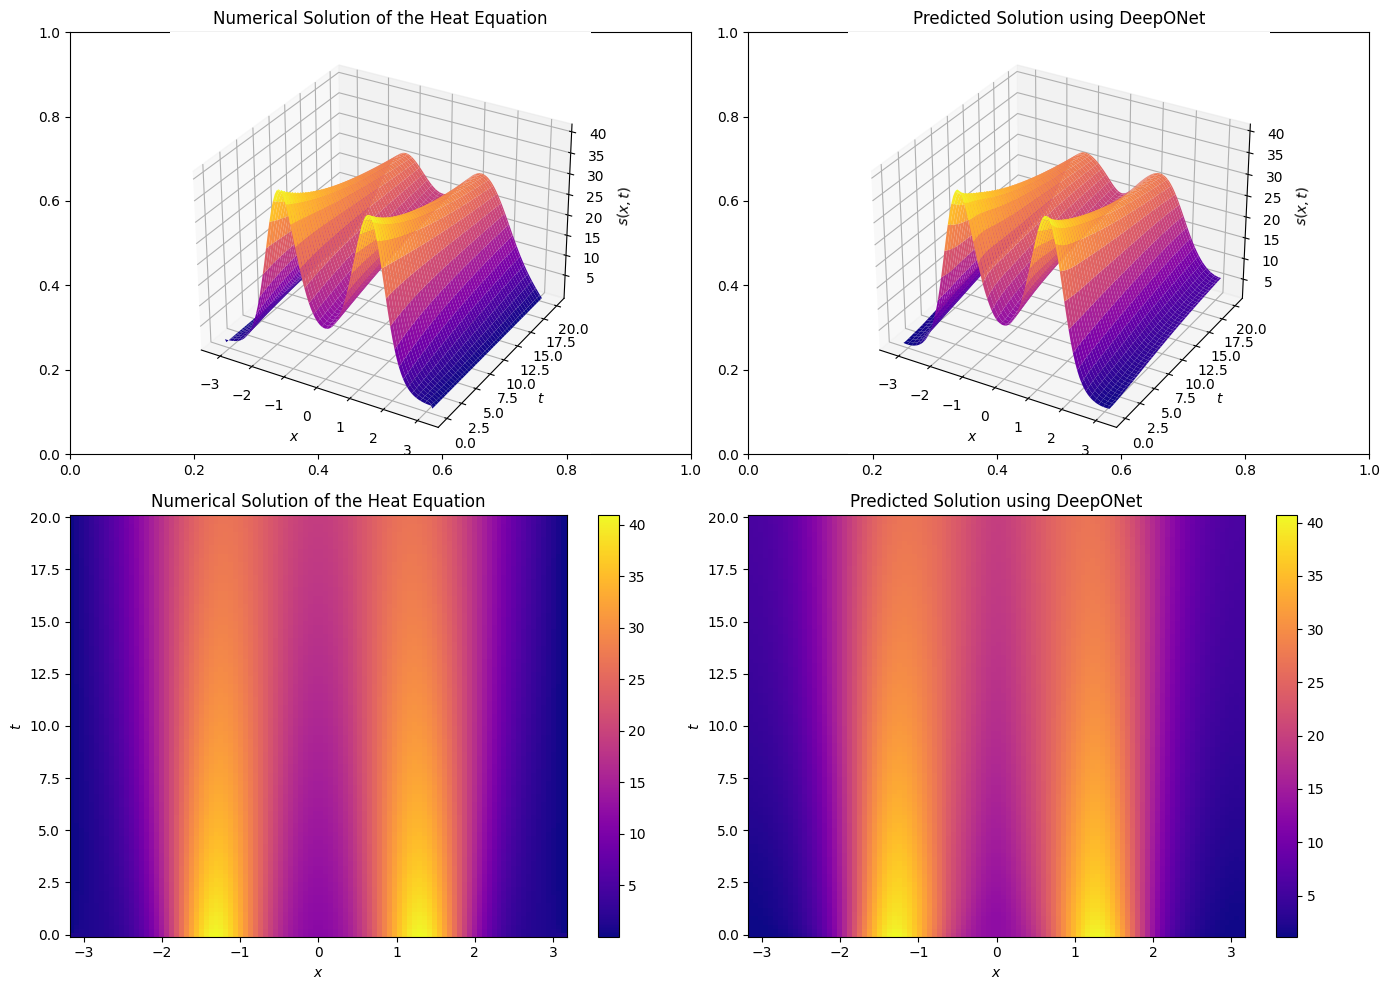

Average fractional test error for unseen function:  0.49666837


In [44]:
# Create a new figure with two rows of subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Top row: 3D plots
# Numerical Solution of the Heat Equation
axs[0, 0] = fig.add_subplot(221, projection='3d')
plot_3d(axs[0, 0], XX, TT, S_test)
axs[0, 0].set_title("Numerical Solution of the Heat Equation", fontsize='large')

# Predicted Solution using DeepONet
axs[0, 1] = fig.add_subplot(222, projection='3d')
plot_3d(axs[0, 1], XX, TT, S_pred)
axs[0, 1].set_title("Predicted Solution using DeepONet", fontsize='large')

# Bottom row: 2D color plots
# Numerical Solution of the Heat Equation
plot(axs[1, 0], XX, TT, S_test)
axs[1, 0].set_title("Numerical Solution of the Heat Equation", fontsize='large')

# Predicted Solution using DeepONet
plot(axs[1, 1], XX, TT, S_pred)
axs[1, 1].set_title("Predicted Solution using DeepONet", fontsize='large')

plt.tight_layout()
plt.show()

print('Average fractional test error for unseen function: ', np.mean((s_test - s_pred)**2) / np.mean((s_test)**2))